# 2026년 1월 1주차 베스트셀러 예측 Validation

학습된 ML 모델로 2026년 1월 1주차 베스트셀러를 예측하고, 실제 데이터와 비교

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

## 1. 데이터 로드

In [5]:
import lightgbm as lgb

# 학습 데이터 로드
ml_data = pd.read_csv('../books_ml_dataset_v4.csv')
actual = pd.read_excel('kyobo_weekly_bestseller_2026011.xlsx')

# === LightGBM 모델 학습 (Feature Selection 8개 + y_lag1) ===
selected_features = ['category_4', 'category_10', 'prophet_forecast_stock_trading',
                     'category_3', 'kospi', 'category_9',
                     'prophet_forecast_financial_crisis', 'category_6']
feature_cols = selected_features + ['y_lag1']

df_lag = ml_data.copy()
df_lag['y_lag1'] = df_lag.groupby('product_code')['y_sales_score'].shift(1)
df_lag = df_lag.dropna(subset=['y_lag1'])

X_train = df_lag[feature_cols]
y_train = df_lag['y_sales_score']

model = lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)
model.fit(X_train, y_train)

from sklearn.metrics import r2_score
train_r2 = r2_score(y_train, model.predict(X_train))

# === 2026년 1월 1주차 예측 ===
last_week = ml_data[ml_data['ymw'] == 2025124].copy()
last_week['y_lag1'] = last_week['y_sales_score']
X_pred = last_week[feature_cols]
last_week['pred_score'] = np.maximum(model.predict(X_pred), 0)

pred = last_week[['product_code', 'y_lag1', 'pred_score']].copy()
pred = pred.sort_values('pred_score', ascending=False).reset_index(drop=True)
pred['pred_rank'] = range(1, len(pred)+1)

print(f'LightGBM Train R²: {train_r2:.4f}')
print(f'예측: {len(pred)}권 | 실제: {len(actual)}권')

LightGBM Train R²: 0.8405
예측: 141권 | 실제: 20권


In [6]:
# 데이터 병합
actual_df = actual[['순위', '판매상품 ID', '상품명']].rename(
    columns={'순위': 'actual_rank', '판매상품 ID': 'product_code', '상품명': 'title'})
pred_df = pred[['product_code', 'pred_rank', 'y_lag1', 'pred_score']]

merged = pd.merge(actual_df, pred_df, on='product_code', how='outer')
merged['actual_rank'] = merged['actual_rank'].fillna(99).astype(int)
merged['pred_rank'] = merged['pred_rank'].fillna(99).astype(int)

## 2. 예측 정확도 분석

In [7]:
actual_top20 = set(actual[actual['순위'] <= 20]['판매상품 ID'])
pred_top20 = set(pred[pred['pred_rank'] <= 20]['product_code'])
matched = actual_top20 & pred_top20

both = merged[(merged['actual_rank']<=20) & (merged['pred_rank']<=20)]
corr = both['actual_rank'].corr(both['pred_rank'])
new_entries = merged[(merged['actual_rank']<=20) & (merged['pred_rank']==99)]

print('='*50)
print('Validation 결과 요약')
print('='*50)
print(f'Top 20 일치율: {len(matched)}/20 ({len(matched)/20*100:.0f}%)')
print(f'순위 상관계수: {corr:.3f}')
print(f'신규 진입: {len(new_entries)}권')

Validation 결과 요약
Top 20 일치율: 10/20 (50%)
순위 상관계수: 0.690
신규 진입: 10권


## 3. 시각화

FileNotFoundError: [Errno 2] No such file or directory: 'ml_image_v4/validation_main_result.png'

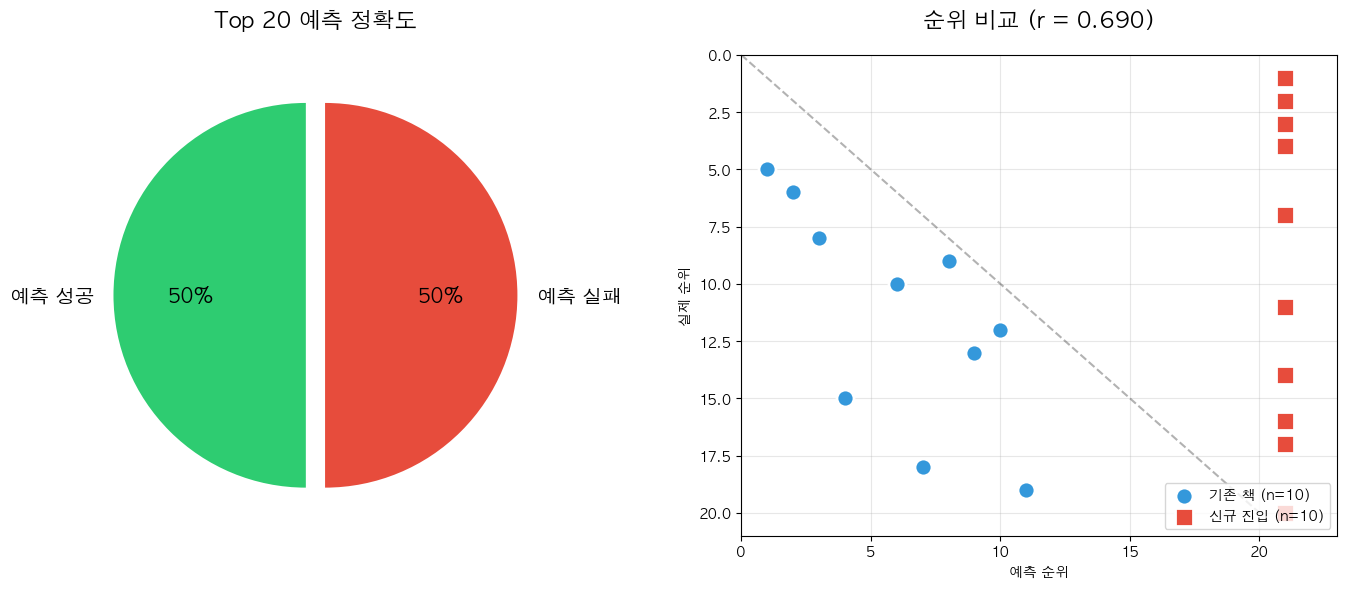

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ax1 = axes[0]
ax1.pie([len(matched), 20-len(matched)], labels=['예측 성공', '예측 실패'],
        colors=['#2ecc71', '#e74c3c'], autopct='%1.0f%%', startangle=90,
        textprops={'fontsize': 14, 'fontweight': 'bold'}, explode=[0.05, 0.05])
ax1.set_title('Top 20 예측 정확도', fontsize=16, fontweight='bold', pad=20)

ax2 = axes[1]
ax2.scatter(both['pred_rank'], both['actual_rank'], s=150, c='#3498db',
            edgecolors='white', linewidth=2, label=f'기존 책 (n={len(both)})', zorder=3)
ax2.scatter([21]*len(new_entries), new_entries['actual_rank'], s=150, c='#e74c3c',
            marker='s', edgecolors='white', linewidth=2, label=f'신규 진입 (n={len(new_entries)})', zorder=3)
ax2.plot([0, 20], [0, 20], 'k--', alpha=0.3)
ax2.set_xlabel('예측 순위'); ax2.set_ylabel('실제 순위')
ax2.set_xlim(0, 23); ax2.set_ylim(0, 21)
ax2.set_title(f'순위 비교 (r = {corr:.3f})', fontsize=16, fontweight='bold', pad=20)
ax2.legend(loc='lower right'); ax2.grid(True, alpha=0.3); ax2.invert_yaxis()

plt.tight_layout()
plt.savefig('ml_image_v4/validation_main_result.png', dpi=200, bbox_inches='tight', facecolor='white')
plt.show()

## 4. 상세 비교 테이블

In [ ]:
print('실제 Top 20 vs 예측 순위')
print('='*60)
for _, r in merged[merged['actual_rank']<=20].sort_values('actual_rank').iterrows():
    title = str(r['title'])[:32] + '...' if len(str(r['title']))>32 else str(r['title'])
    pred_str = str(int(r['pred_rank'])) if r['pred_rank'] < 99 else 'NEW'
    status = '기존' if r['pred_rank'] < 99 else '신규'
    print(f'{r["actual_rank"]:>2}위 | 예측:{pred_str:>3} [{status}] {title}')

실제 Top 20 vs 예측 순위
 1위 | 예측:NEW [신규] 돈의 방정식
 2위 | 예측:NEW [신규] 진보를 위한 주식투자
 3위 | 예측:NEW [신규] 자본주의 시대에서 살아남기 위한 최소한의 경제 공부
 4위 | 예측:NEW [신규] 캔들차트 하나로 끝내는 추세추종 투자
 5위 | 예측:  1 [기존] 트렌드 코리아 2026
 6위 | 예측:  2 [기존] 박곰희 연금 부자 수업
 7위 | 예측:NEW [신규] 돈의 심리학(50만 부 기념 뉴 에디션)
 8위 | 예측:  3 [기존] ETF 투자의 모든 것
 9위 | 예측:  8 [기존] 돈의 속성(400쇄 리커버에디션)
10위 | 예측:  6 [기존] 이코노미스트 2026 세계대전망
11위 | 예측:NEW [신규] 텐배거 포트폴리오
12위 | 예측: 10 [기존] 자본주의
13위 | 예측:  9 [기존] 시대예보: 경량문명의 탄생(시리즈 30만부 기념 리커버 한...
14위 | 예측:NEW [신규] 부에 이르는 가장 단순한 길
15위 | 예측:  4 [기존] 머니 트렌드 2026
16위 | 예측:NEW [신규] 이름값 경제학
17위 | 예측:NEW [신규] 더 코인 THE COIN
18위 | 예측:  7 [기존] AI 2026 트렌드&활용백과
19위 | 예측: 11 [기존] 실패를 통과하는 일
20위 | 예측:NEW [신규] 2026~2027 대한민국 산업지도


## 5. 순위 변동 예측 분석

In [ ]:
# 전주 순위 계산
last_week = ml_data[ml_data['ymw'] == 2025124][['product_code', 'y_sales_score']].copy()
last_week = last_week.sort_values('y_sales_score', ascending=False).reset_index(drop=True)
last_week['prev_rank'] = range(1, len(last_week)+1)

# 병합
rank_df = pd.merge(last_week[['product_code', 'prev_rank']], 
                   actual[['판매상품 ID', '순위', '상품명']].rename(
                       columns={'판매상품 ID': 'product_code', '순위': 'actual_rank', '상품명': 'title'}),
                   on='product_code', how='outer')
rank_df = pd.merge(rank_df, pred[['product_code', 'pred_rank']], on='product_code', how='outer')

for col in ['prev_rank', 'actual_rank', 'pred_rank']:
    rank_df[col] = rank_df[col].fillna(99).astype(int)

rank_df['actual_change'] = rank_df['actual_rank'] - rank_df['prev_rank']
rank_df['pred_change'] = rank_df['pred_rank'] - rank_df['prev_rank']

def classify_change(change, prev, curr):
    if prev == 99: return 'NEW'
    elif curr == 99: return 'OUT'
    elif change < -2: return 'UP'
    elif change > 2: return 'DOWN'
    else: return 'STAY'

rank_df['actual_dir'] = rank_df.apply(lambda r: classify_change(r['actual_change'], r['prev_rank'], r['actual_rank']), axis=1)
rank_df['pred_dir'] = rank_df.apply(lambda r: classify_change(r['pred_change'], r['prev_rank'], r['pred_rank']), axis=1)

analysis = rank_df[(rank_df['prev_rank'] <= 20) | (rank_df['actual_rank'] <= 20)].copy()

In [ ]:
print('='*60)
print('순위 변동 예측 분석')
print('='*60)

same_dir = (analysis['actual_dir'] == analysis['pred_dir']).sum()
print(f'\n[전체 방향 예측 정확도]: {same_dir}/{len(analysis)} ({same_dir/len(analysis)*100:.1f}%)')

print(f'\n[실제 순위 변동 분포]')
for d in ['UP', 'STAY', 'DOWN', 'NEW', 'OUT']:
    cnt = (analysis['actual_dir'] == d).sum()
    if cnt > 0: print(f'  {d:>4}: {cnt}개')

predictable = analysis[analysis['actual_dir'] != 'NEW']
correct = (predictable['actual_dir'] == predictable['pred_dir']).sum()
print(f'\n[신규 진입 제외 정확도]: {correct}/{len(predictable)} ({correct/len(predictable)*100:.1f}%)')

print(f'\n[핵심 문제점]')
print(f'  - 모델 예측: 대부분 STAY (관성 효과 가정)')
print(f'  - 실제 결과: 대부분 DOWN (신간에 밀려 하락)')

순위 변동 예측 분석

[전체 방향 예측 정확도]: 11/30 (36.7%)

[실제 순위 변동 분포]
  STAY: 1개
  DOWN: 9개
   NEW: 10개
   OUT: 10개

[신규 진입 제외 정확도]: 1/20 (5.0%)

[핵심 문제점]
  - 모델 예측: 대부분 STAY (관성 효과 가정)
  - 실제 결과: 대부분 DOWN (신간에 밀려 하락)


In [ ]:
print('\n[순위 변동 상세]')
print('-'*70)
print(f'{"전주":>4} {"실제":>4} {"예측":>4} {"실제변동":>8} {"예측변동":>8} {"일치":>4}  책제목')
print('-'*70)

for _, r in analysis.sort_values('actual_rank').head(20).iterrows():
    prev = r['prev_rank'] if r['prev_rank'] < 99 else '-'
    act = r['actual_rank'] if r['actual_rank'] < 99 else '-'
    prd = r['pred_rank'] if r['pred_rank'] < 99 else '-'
    match = 'O' if r['actual_dir'] == r['pred_dir'] else 'X'
    title = str(r['title'])[:20] if pd.notna(r['title']) else '?'
    print(f'{str(prev):>4} {str(act):>4} {str(prd):>4} {r["actual_dir"]:>8} {r["pred_dir"]:>8} {match:>4}  {title}')


[순위 변동 상세]
----------------------------------------------------------------------
  전주   실제   예측     실제변동     예측변동   일치  책제목
----------------------------------------------------------------------
   -    1    -      NEW      NEW    O  돈의 방정식
   -    2    -      NEW      NEW    O  진보를 위한 주식투자
   -    3    -      NEW      NEW    O  자본주의 시대에서 살아남기 위한 최소
   -    4    -      NEW      NEW    O  캔들차트 하나로 끝내는 추세추종 투자
   1    5    1     DOWN     STAY    X  트렌드 코리아 2026
   2    6    2     DOWN     STAY    X  박곰희 연금 부자 수업
   -    7    -      NEW      NEW    O  돈의 심리학(50만 부 기념 뉴 에디
   3    8    3     DOWN     STAY    X  ETF 투자의 모든 것
   8    9    8     STAY     STAY    O  돈의 속성(400쇄 리커버에디션)
   6   10    6     DOWN     STAY    X  이코노미스트 2026 세계대전망
   -   11    -      NEW      NEW    O  텐배거 포트폴리오
   9   12   10     DOWN     STAY    X  자본주의
  10   13    9     DOWN     STAY    X  시대예보: 경량문명의 탄생(시리즈 3
   -   14    -      NEW      NEW    O  부에 이르는 가장 단순한 길
   4   15    4     DOWN     STAY    X  머니 트렌드 2

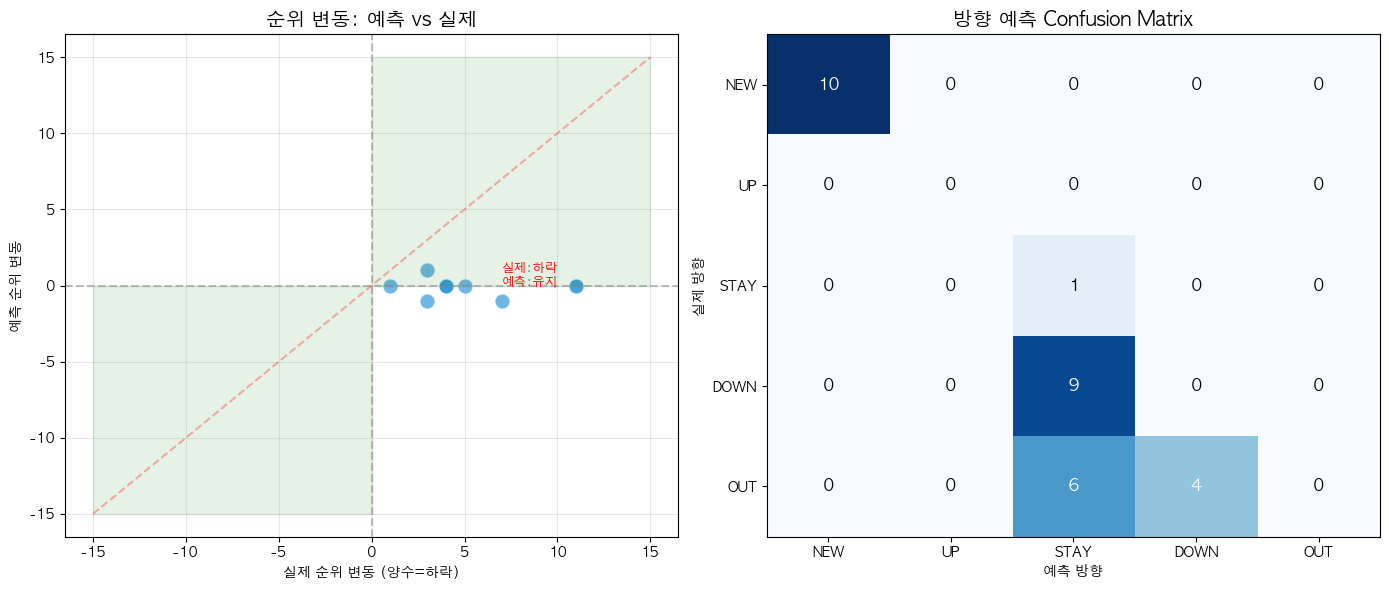

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. 순위 변동 scatter
ax1 = axes[0]
plot_df = analysis[(analysis['prev_rank'] < 99) & (analysis['actual_rank'] < 99)]
ax1.scatter(plot_df['actual_change'], plot_df['pred_change'], s=120, alpha=0.7, c='#3498db', edgecolors='white')
ax1.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax1.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax1.plot([-15, 15], [-15, 15], 'r--', alpha=0.3)
ax1.set_xlabel('실제 순위 변동 (양수=하락)')
ax1.set_ylabel('예측 순위 변동')
ax1.set_title('순위 변동: 예측 vs 실제', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.fill_between([0, 15], [0, 0], [15, 15], alpha=0.1, color='green')
ax1.fill_between([-15, 0], [-15, -15], [0, 0], alpha=0.1, color='green')
ax1.text(7, 0, '실제:하락\n예측:유지', fontsize=9, color='red')

# 2. Confusion Matrix
ax2 = axes[1]
directions = ['NEW', 'UP', 'STAY', 'DOWN', 'OUT']
matrix = pd.crosstab(analysis['actual_dir'], analysis['pred_dir'])
matrix = matrix.reindex(index=directions, columns=directions, fill_value=0)

im = ax2.imshow(matrix.values, cmap='Blues', aspect='auto')
ax2.set_xticks(range(len(directions))); ax2.set_yticks(range(len(directions)))
ax2.set_xticklabels(directions); ax2.set_yticklabels(directions)
ax2.set_xlabel('예측 방향'); ax2.set_ylabel('실제 방향')
ax2.set_title('방향 예측 Confusion Matrix', fontsize=14, fontweight='bold')

for i in range(len(directions)):
    for j in range(len(directions)):
        val = matrix.values[i, j]
        color = 'white' if val > 3 else 'black'
        ax2.text(j, i, val, ha='center', va='center', fontsize=12, fontweight='bold', color=color)

plt.tight_layout()
plt.savefig('ml_image_v4/validation_rank_change.png', dpi=200, bbox_inches='tight', facecolor='white')
plt.show()

## 6. 결론

In [ ]:
print('\n저장된 이미지:')
print('  - ml_image_v4/validation_main_result.png')
print('  - ml_image_v4/validation_rank_change.png')
print('  - ml_image_v4/validation_conclusion.png')


저장된 이미지:
  - ml_image_v4/validation_main_result.png
  - ml_image_v4/validation_rank_change.png
  - ml_image_v4/validation_conclusion.png
